In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt          # Para gráficos
import seaborn as sns                    # Para gráficos
import scipy.stats as stats              # Para calcular funciones de densidad
import statsmodels.api as sm             # Para modelos
import statsmodels.formula.api as smf    # Para regresión logística
from scipy.stats import chi2_contingency # Test de independencia
from imblearn.over_sampling import SMOTE # Remuestreo
from sklearn import metrics              # Matriz de confusión y otras medidas de clasif
from sklearn.model_selection import train_test_split # Dividir datos en entrenamiento y test
import os

# Modelos de respuesta binaria

Cuando la variable que queremos explicar (o predecir) es binaria, es decir asume valores 0 y 1, modelamos la probabilidad de ocurrencia del suceso que mide esta variable. Este problema podemos abordarlo:

1. Como en las prácticas vistas anteriormente, mediante el ajuste de un **modelo de regresión lineal** por Mínimos Cuadrados Ordinarios con statsmodels.OLS() pero en este caso con una variable de respuesta binaria. Este modelo tiene ciertas ventajas y desventajas. Es simple de interpretar y comunicar resultados porque los coeficientes $\beta$ ajustados son directamente interpretables, pero puede predecir probabilidades mayores a 1 o menores a 0 en los extremos y estima efectos marginales constantes lo cual puede no ser útil siempre. Son conocidos como Modelos Lineales de Probabilidad (MLP).

2. Con **modelos de regresión logísticos**, que admiten distribuciones asociadas a las variables binarias distintas a la normal y son ajustados por Máxima Verosimilitud.

# Regresión logística

La regresión logística estima la probabilidad de que ocurra un evento condicionado a un conjunto de variables independientes. Asume que la variable binaria a modelar proviene de una distribución Binomial (Bernoulli). Este modelo forma parte de la familia de los Modelos Lineales Generalizados (MLG) que extienden al Modelo Lineal Clásico visto en las prácticas anteriores admitiendo distribuciones diferentes a la normal y modelando *funciones* de los parámetros que nos interesan.

En logísticos, nos interesa modelar la probabilidad de ocurrencia de un evento (parámetro $p$ de una Bernoulli) condicionado a variables explicativas. Para ello, el modelo tranforma la probabilidad mediante la función de enlace logit con el objetivo de poder estimar una función lineal (o predictor lineal $\eta$).

1. $Y \sim B(1,p)$

2. $z=\beta_0+\beta_1x_1+\beta_2x_2...=x\beta$

3. $g(p)=logit(p)=logit(P(Y=1/x\beta))=z$

La función logit nos permite utilizar la función de distribución de acumulada de una variable aleatoria con distribución logística. Por lo tanto, para estimar las probabilidades predichas el modelo utiliza la función de densidad acumulada (fda) y para estimar efectos marginales la función de densidad de probabilidad (fdp).

FDA: $F(x)=\frac{exp(z)}{1+\exp(z)}$

FDP: $f(x)=\frac{exp(z)}{[1+exp(z)]^2}$

In [53]:
#  ==== OBTENCION DE DATOS

# Obtén la ruta absoluta del arhivo actual
current_dir = os.getcwd() 

path_datasets = os.path.join(current_dir,"datasets")


path_diabetes = os.path.join(path_datasets,"Diabetes.xlsx") 

datos = pd.read_excel(path_diabetes)
datos

,ID,EDAD,SEXO,PESO,TALLA,DM,SEDENT,TAS,TAD,HTA_OMS,ECV_B,TABACO,ALCOHOL,STATIN,CINTURA,CADERA,OBCENT_ATP,COLEST
0,11,44,1,63.9,163.0,0,0,115.000,85,0,0,0,0,1,95.0,96,0,213
1,23,37,0,63.2,157.5,0,1,130.065,80,0,0,0,0,0,90.0,96,1,216
2,38,67,1,70.2,145.0,1,1,190.000,95,1,0,0,0,0,106.5,110,1,231
3,50,78,0,88.9,157.0,0,1,140.000,80,1,1,0,0,0,126.0,132,1,268
4,65,33,1,81.8,175.0,0,0,120.000,80,0,0,1,1,0,86.0,89,0,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1305,46,0,76.0,168.0,0,1,120.000,80,0,0,1,0,0,93.0,107,1,182
76,1337,41,0,62.0,159.0,0,1,110.000,80,0,0,0,1,0,82.0,99,0,174
77,1344,40,1,80.0,175.0,0,1,110.000,80,0,0,0,1,0,95.0,104,0,207
78,1373,42,0,60.9,166.0,0,0,130.000,80,0,0,1,0,0,80.0,94,0,256


**Descripción de variables**

* EDAD: edad, expresada en años.
* SEXO: sexo, codificado con 0 para Hombres y 1 para Mujeres.
* PESO: peso, expresado en kilogramos.
* TALLA: talla, expresada en cm.
* DM: Indicadora de presencia de Diabetes Mellitus.
* SEDENT: indicadora de ser o no sedentario.
* TAS: Presión arterial sistólica, en mmHg.
* TAD: Presión arterial diastólica, en mmHg.
* HTA_OMS: Indicadora de padecer hipertensión arterial, según lo definido por la OMS.
* ECV_B: indicadora de padecer enfermedades cardiovasculares.
* TABACO: indicadora de ser fumador.
* ALCOHOL: indicadora de beber alcohol regularmente.
* STATIN: indicadora de consumo de Estanina (medicamento indicado para bajar
colesterol y triglicéridos)
* CINTURA: perímetro, expresado en cm.
* CADERA: perímetro, expresado en cm.
* OBCENT_ATP: indicadora de obesidad central.
* COLESTEROL: colesterol total, en md/dL.


## Análisis descriptivo

La variable que queremos modelar es la presencia de diabetes medida con la variable binaria 'DM'. Si vemos el conteo de casos en la muestra, además de contar con un número de observaciones un poco reducido, tenemos sólo 8 casos positivos con diabetes. Lo cual representa el 10% de las observaciones.

In [54]:
datos['DM'].value_counts()

DM
0    72
1     8
Name: count, dtype: int64

In [55]:
datos['DM'].value_counts(normalize=True) #--> Muestra la densidad

DM
0    0.9
1    0.1
Name: proportion, dtype: float64

**Presencia de Diabetes Mellitus (DM) según variables numéricas**

Estudiar de esa forma facilita ver como la presencia de cierta caracteristica afecta a una variable

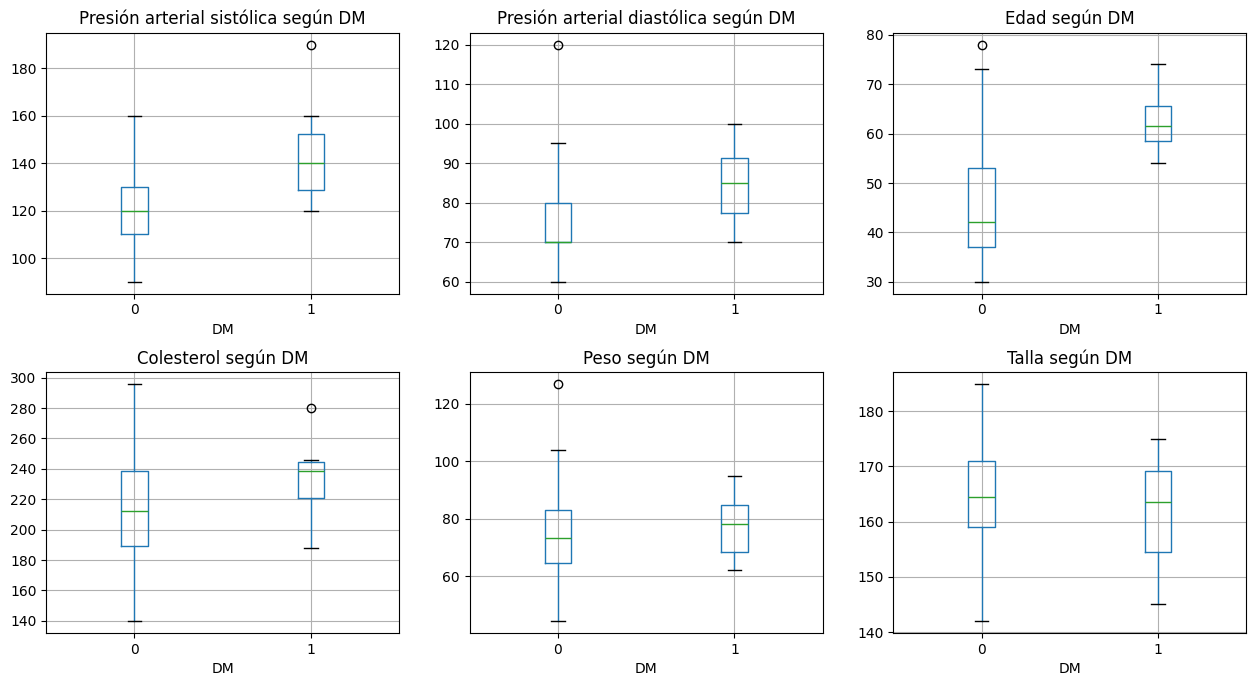

In [56]:
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

# Presión arterial sistólica según presencia o no de DM
datos.boxplot(column='TAS', by = 'DM', ax=ax[0,0])
ax[0,0].set_title("Presión arterial sistólica según DM")

# Presión arterial diastólica según presencia o no de DM
datos.boxplot(column='TAD', by = 'DM', ax=ax[0,1])
ax[0,1].set_title("Presión arterial diastólica según DM")

# Edad según presencia o no de DM
datos.boxplot(column='EDAD', by = 'DM', ax=ax[0,2])
ax[0,2].set_title("Edad según DM")

# Colesterol según presencia o no de DM
datos.boxplot(column='COLEST', by = 'DM', ax=ax[1,0])
ax[1,0].set_title("Colesterol según DM")

# Peso según presencia o no de DM
datos.boxplot(column='PESO', by = 'DM', ax=ax[1,1])
ax[1,1].set_title("Peso según DM")

# Talla según presencia o no de DM
datos.boxplot(column='TALLA', by = 'DM', ax=ax[1,2])
ax[1,2].set_title("Talla según DM")

fig.suptitle('')
plt.subplots_adjust(hspace=0.3)
plt.show()

**Presencia de Diabetes Mellitus (DM) según variables categóricas**

In [57]:
pd.crosstab(datos['DM'],datos['HTA_OMS'], normalize=True, margins=True) * 100

HTA_OMS,0,1,All
DM,,,
0,66.25,23.75,90.0
1,1.25,8.75,10.0
All,67.50,32.50,100.0


## Test de asociación $\chi^2$


El test chi-cuadrado nos permite determinar si existe independencia o no entre dos variable categóricas de mi conjunto de datos. Es decir, comprueba si estas variables están asociadas.

El estadístico $\chi^2$ se calcula con la siguiente fórmula, donde $f_e$
y $f_o$ son las frecuencias esperadas y frecuencias observadas,
respectivamente, $r$ es el número de filas de la tabla y $c$ el número
de columnas.

$$
\chi^2=\sum{\frac{(f_e-f_o)^2}{f_e} \sim \chi^2_{(r-1)(c-1)}}
$$

<hr>

Dato: para la explicacion, mi veredicto para aceptar o rechazar la $H_0$ es la comparacion entre el p valor obtenido, y el nivel de signficancia con el que se comenzo a trabajar.

**Test: DM vs HTA_OMS**

$H_0:$ no existe asociación entre la presencia de diabetes y la presencia de hipertensión arterial.

$H_1:$ existe asociación entre la presencia de diabetes y la presencia de hipertensión arterial

In [58]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['HTA_OMS']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  9.6296
p-value =  0.0019


Se rechaza la hipótesis nula, por lo cual tenemos evidencia de que existe asociación entre la presencia de diabetes y la hipertensión arterial.


**Test: DM vs TABACO**

$H_0:$ no existe asociación entre la presencia de diabetes y el consumo de tabaco.

$H_1:$ existe asociación entre la presencia de diabetes y el consumo de tabaco.

In [59]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['TABACO']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  0.9117
p-value =  0.3397


No podemos rechazar la nula de que no existe asociación entre las variables. Porque mi $p$ < $\alpha$

**Test: DM vs SEDENT**

$H_0:$ no existe asociación entre la presencia de diabetes y que la persona sea sedentaria.

$H_1:$ existe asociación entre la presencia de diabetes y que la persona sea sedentaria.

In [60]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['SEDENT']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  1.6096
p-value =  0.2046


No podemos rechazar la nula de que no existe asociación entre las variables. Porque mi $p$ < $\alpha$

**Test: DM vs OBCENT_ATP**

$H_0:$ no existe asociación entre la presencia de diabetes y la presencia de obesidad central.

$H_1:$ existe asociación entre la presencia de diabetes y la presencia de obesidad central.

In [61]:
prueba_chi2 = chi2_contingency(pd.crosstab(datos['DM'],datos['OBCENT_ATP']))
print("Estadístico chi2 = ", prueba_chi2[0].round(4))
print("p-value = ", prueba_chi2[1].round(4))

Estadístico chi2 =  2.7041
p-value =  0.1001


No podemos rechazar la nula de que no existe asociación entre las variables. Porque mi $p$ < $\alpha$

## Modelos para inferencia

Nuestro objetivo es modelar la probabilidad de tener diabetes para los individuos de la muestra.

Como primer ajuste, incluimos como variable explicativa a la presión arterial sistólica (TAS) y vemos resultados.

In [62]:
reg_log = smf.logit(formula='DM ~ TAS', data=datos).fit() #--> Se uso solo una variable independiente (Tas, que es la presion arterial)
print(reg_log.summary())

Optimization terminated successfully.
         Current function value: 0.230497
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                     DM   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Jul 2024   Pseudo R-squ.:                  0.2910
Time:                        16:14:51   Log-Likelihood:                -18.440
converged:                       True   LL-Null:                       -26.007
Covariance Type:            nonrobust   LLR p-value:                 0.0001002
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -14.1996      4.163     -3.411      0.001     -22.358      -6.041
TAS            0.0927      0.

De la salida anterior debemos tener en cuenta que sólo podemos interpretar el signo del coeficiente asociado a la variable TAS, es decir su dirección positiva en este caso. El valor del coeficiente no es directamente interpretable como efecto marginal dado que el modelo estima una **función** (intermedia) de la probabilidad. Para llegar a obtener las probabilidades predichas, los valores ajustados requieren ser evaluados en la fdp logística. Esto podemos hacerlo automáticamente con la función predict() que nos calcula las probabilidades predichas.

*Método: MLE hace referencia a Maximun likelihood estimation

Vemos gráficamente el ajuste del modelo, ya que estamos trabajando con una sola variable explicativa:

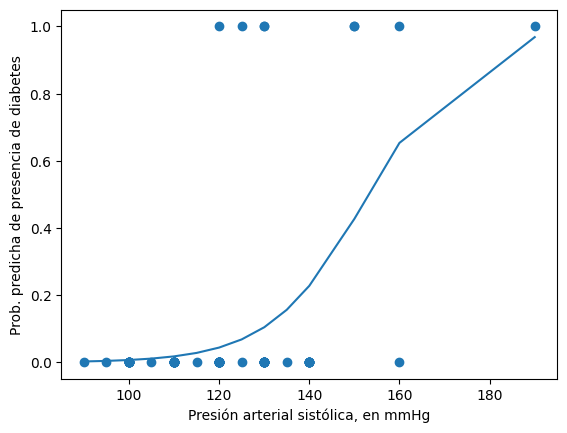

In [63]:
""" Como es posible esta prediccion? 

Explicación de las Predicciones
reg_log.predict(datos):

- Esta línea hace predicciones para todas las filas del DataFrame datos utilizando el modelo ajustado reg_log.

- Aunque el DataFrame datos pueda contener muchas variables, el modelo solo usa las variables especificadas en la fórmula (DM y TAS) para hacer las predicciones.

- Específicamente, reg_log.predict(datos) toma los valores de TAS en datos y calcula la probabilidad predicha de DM para cada fila.

"""

datos.sort_values(by='TAS', inplace=True)
datos['predichos'] = reg_log.predict(datos)

plt.scatter(datos['TAS'], datos['DM'])
plt.plot(datos['TAS'], datos['predichos'])
plt.xlabel('Presión arterial sistólica, en mmHg')
plt.ylabel('Prob. predicha de presencia de diabetes')
plt.show()

**¿Para que sirven los calculos que de ahora en adelante se muestran?**

Sirven para evaluar el modelo en sus distintas predicciones, ya que la interpretacion de los coeficientes no son utiles mas haya de su signo. Los calculos siguientes muestran casos mas puntuales y sobre todo REALES que pueden pasar los datos.